In [132]:
### Create map of plööp

### IMPORT DATA ###

# Import modules
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopandas.tools import geocode
import numpy as np
from pyproj import CRS
import requests
import geojson
import matplotlib.pyplot as plt
from shapely.ops import cascaded_union
import mapclassify
import contextily as ctx

## Read shape file containing the capital region as polygons into variable 'grid' (Data from https://tiedostopalvelu.maanmittauslaitos.fi/tp/kartta)
# File path
fp_grid = "data/pkseutu.shp"

# Read in data
grid = gpd.read_file(fp_grid)

# Check if crs is correct and set crs to ETRS89 / TM35FIN if the crs is not defined correctly
if (grid.crs != "epsg:3067"):    
    grid = grid.set_crs(epsg=3067)
# Reproject to WGS 84 / Pseudo-Mercator if the crs is not defined correctly
if (grid.crs != "epsg:3857"):    
    grid = grid.to_crs(epsg=3857)

# Check the data
print(grid.head())
print(grid.crs)

     GML_ID NATCODE     NAMEFIN      NAMESWE  LANDAREA  FRESHWAREA  SEAWAREA  \
0  27817426     091    Helsinki  Helsingfors    214.25        0.91    500.32   
1  27806267     049       Espoo         Esbo    312.32       17.91    197.80   
2  27817421     092      Vantaa        Vanda    238.37        1.98      0.00   
3  27806296     235  Kauniainen    Grankulla      5.89        0.11      0.00   

   TOTALAREA                                           geometry  
0     715.48  POLYGON ((2804165.799 8463618.196, 2804168.439...  
1     528.03  POLYGON ((2764219.067 8456519.067, 2764250.094...  
2     240.35  POLYGON ((2804165.799 8463618.196, 2804091.743...  
3       6.00  POLYGON ((2753937.589 8448624.411, 2753958.644...  
epsg:3857


In [133]:
## Read population grid data for 2018 into a variable `pop`. 

# Specify the url for web feature service
url = 'https://kartta.hsy.fi/geoserver/wfs'

# Specify parameters (read data in json format).
params = dict(service='WFS',
              version='2.0.0',
              request='GetFeature',
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018',
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url, params=params)

# Create GeoDataFrame from geojson
pop = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

# Clean out unnecessary columns
pop = pop[["asukkaita", "geometry"]]

# Set crs to ETRS89 / GK25FIN and reproject to WGS 84 / Pseudo-Mercator if the crs is not defined correctly
if (pop.crs == None):    
    pop = pop.set_crs(epsg=3879)
if (pop.crs != "epsg:3857"):    
    pop = pop.to_crs(epsg=3857)

# Check the data
print(pop.head())
print(pop.crs)

   asukkaita                                           geometry
0        108  MULTIPOLYGON Z (((2735848.290 8440015.529 0.00...
1        273  MULTIPOLYGON Z (((2736346.567 8440521.047 0.00...
2        239  MULTIPOLYGON Z (((2736832.315 8443036.322 0.00...
3        202  MULTIPOLYGON Z (((2736835.465 8442533.836 0.00...
4        261  MULTIPOLYGON Z (((2736838.614 8442031.385 0.00...
epsg:3857


In [134]:
## Read buffer polygons that describe 200 m accessibility via pedestrian and bicycle ways from metro and train stations 

# Specify the url for web feature service
url_buff = 'https://kartta.hsy.fi/geoserver/wfs'

# Specify parameters (read data in json format).
params_buff = dict(service='WFS',
              version='2.0.0',
              request='GetFeature',
              typeName='800m_verkostobufferi',
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url_buff, params=params_buff)

# Create GeoDataFrame from geojson
buff = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

# Clean out unnecessary columns
buff = buff[["asema", "geometry"]]

# Set crs to ETRS89 / GK25FIN and reproject to WGS 84 / Pseudo-Mercator if the crs is not defined correctly
if (buff.crs == None):    
    buff = buff.set_crs(epsg=3879)
if (buff.crs != "epsg:3857"):    
    buff = buff.to_crs(epsg=3857)
    
# Clip out stations that are located outside the capital region
#polygons = [grid.at[0,'geometry'], grid.at[1,'geometry'], grid.at[2,'geometry'], grid.at[3,'geometry']]
#boundary = gpd.GeoSeries(cascaded_union(polygons))
#boundary = boundary.set_crs(epsg=3067)
grid['constant'] = 0
boundary = grid.dissolve(by='constant')

clip_mask = buff.within(boundary.at[0,'geometry'])
buff = buff.loc[clip_mask]
#gpd.clip(buff, boundary)

# Check the data
print(buff.head())
print(len(buff))

             asema                                           geometry
0             Kilo  MULTIPOLYGON (((2759279.008 8447422.698, 27592...
1             Kera  MULTIPOLYGON (((2755991.373 8449347.798, 27560...
2        Itäkeskus  MULTIPOLYGON (((2791809.391 8448037.660, 27918...
3  Aalto-yliopisto  MULTIPOLYGON (((2763983.812 8442294.758, 27640...
4           Mankki  MULTIPOLYGON (((2737001.272 8442410.212, 27370...
64


In [135]:
### PROCESS DATA ###

# Create new column to 'buff' where total resident amounts within buffer areas are stored 
buff["residents_sum"] = None

# Create a spatial join between grid layer and buffer layer. "Intersects" option used here to include all grid cells which touch the buffer area.
pop_combined = gpd.sjoin(pop, buff, how="left", op="intersects")

# Group the data by train and metro station names
grouped = pop_combined.groupby('asema')

# Store sum of residents living approximately 800 m from station to column "sum" 
# (the distance doesn't stay constant in performed analysis but accurate enough for this visualization)
for name, group in grouped:
    buff.at[buff["asema"]==name, "residents_sum"] = group["asukkaita"].agg("sum")
    
# Convert the buffer polygons to points (centroids, approximate of the station locations)
points = buff
points.geometry = points['geometry'].centroid

# Reorganize the column order
points = points[["geometry","asema","residents_sum"]]

# Replace NoData in residents_sum column with 0
points["residents_sum"] = points["residents_sum"].replace(to_replace=np.nan, value=0)
    
# Check data    
print(points.tail())
type(points)

                           geometry       asema  residents_sum
75  POINT (2766801.462 8458172.277)    Myyrmäki          12270
76  POINT (2777480.636 8440177.672)   Hakaniemi          29435
77  POINT (2771067.346 8448501.485)  Huopalahti          10619
78  POINT (2782227.705 8453847.006)   Pukinmäki           9111
79  POINT (2784237.773 8455858.476)       Malmi           9573


geopandas.geodataframe.GeoDataFrame

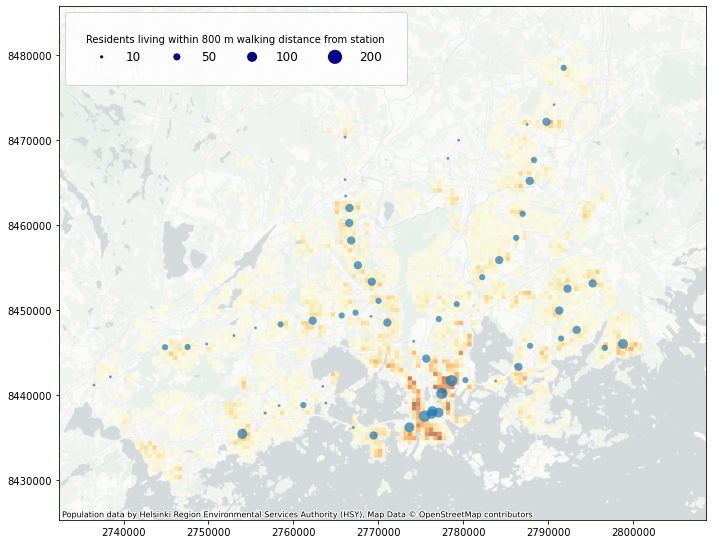

In [158]:
### PLOT DATA ###
# Create one subplot
fig, ax = plt.subplots(figsize=(12,8))


# Add population grid to plot
pop.plot(ax=ax, column="asukkaita", cmap="YlOrBr", alpha=0.6)


## Create lists of lon and lat values
x = points['geometry'].apply(lambda p: p.x) #points.loc[p,'geometry'].x
y = points['geometry'].apply(lambda p: p.y) #points.loc[p,'geometry'].y


## Create list of resident sums as classified values
# Create a Natural Breaks classifier
classifier = mapclassify.NaturalBreaks.make(k=5)

# Classify the data
points["class"] = points[['residents_sum']].apply(classifier)
sizes = [points["class"]*30+8]


# Add residents amounts as a scatter plot to plot
#points.scatter(ax=ax, column="residents_sum")
ax.scatter(x, y, zorder=10, s=sizes, cmap="dimgrey", alpha=0.7, edgecolors='none')

## Adding basemap
# Specify the basemap style to use
style = "light_nolabels"
cartodb_url = 'https://a.basemaps.cartocdn.com/%s/{z}/{x}/{y}.png' % style

## Add attribution
credits = "Population data by Helsinki Region Environmental Services Authority (HSY), Map Data © OpenStreetMap contributors"

# Add basemap with `OSM_A` style 
ctx.add_basemap(ax, attribution=credits, source=cartodb_url)


# Remove the empty white-space around the axes
plt.tight_layout()


## Add legends
# Legend for point data
l1 = plt.scatter([],[], s=10, color="darkblue", edgecolors='none')
l2 = plt.scatter([],[], s=50, color="darkblue", edgecolors='none')
l3 = plt.scatter([],[], s=100, color="darkblue", edgecolors='none')
l4 = plt.scatter([],[], s=200, color="darkblue", edgecolors='none')

labels = ["10", "50", "100", "200"]

ax.legend([l1, l2, l3, l4], labels, ncol=4, frameon=True, fontsize=12,
handlelength=2, loc = 2, borderpad = 1.8,
handletextpad=1, title='Residents living within 800 m walking distance from station', scatterpoints = 1)

# Legend for grid data


# Disable scientific notation
ax.ticklabel_format(style='plain')